##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Fine tuning a custom model

Welcome back to the Kaggle 5-day Generative AI course!

In this notebook you will use the Gemini API to fine-tune a custom, task-specific model. Fine-tuning can be used for a variety of tasks from classic NLP problems like entity extraction or summarisation, to creative tasks like stylised generation. You will fine-tune a model to classify the category a piece of text (a newsgroup post) into the category it belongs to (the newsgroup name).

This codelab walks you tuning a model with the API. [AI Studio](https://aistudio.google.com/app/tune) also supports creating new tuned models directly in the web UI, allowing you to quickly create and monitor models using data from Google Sheets, Drive or your own files.

In [1]:
%pip install -U -q 'google-generativeai>=0.8.3'

Note: you may need to restart the kernel to use updated packages.


Note that you do not have to restart the kernel.

In [2]:
import google.generativeai as genai

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
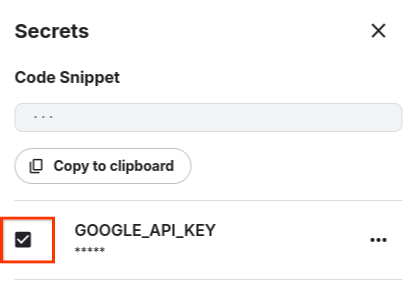

### Explore available models

You will be using the [`TunedModel.create`](https://ai.google.dev/api/tuning#method:-tunedmodels.create) API method to start the fine-tuning job and create your custom model. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about tuning models in [the model tuning docs](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?lang=python).

In [4]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


## Download the dataset

In this activity, you will use the same newsgroups dataset that you used to train a classifier in Keras. In this example you will use a fine-tuned Gemini model to achieve the same goal.

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here's what a single row looks like.

In [6]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Prepare the dataset

You'll use the same pre-processing code you used for the custom model on day 2. This pre-processing removes personal information, which can be used to "shortcut" to known users of a forum, and formats the text to appear a bit more like regular text and less like a newsgroup post (e.g. by removing the mail headers). This normalisation allows the model to generalise to regular text and not over-depend on specific fields. If your input data is always going to be newsgroup posts, it may be helpful to leave this structure in place if they provide genuine signals.

In [7]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [8]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Now sample the data. You will keep 50 rows for each category for training. Note that this is even fewer than the Keras example, as this technique (parameter-efficient fine-tuning, or PEFT) updates a relatively small number of parameters and does not require training a new model or updating the large model.

In [9]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

## Evaluate baseline performance

Before you start tuning a model, it's good practice to perform an evaluation on the available models to ensure you can measure how much the tuning helps.

First identify a single sample row to use for visual inspection.

In [10]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


Passing the text directly in as a prompt does not yield the desired results. The model will attempt to respond to the message.

In [13]:
from IPython.display import Markdown
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
Markdown(response.text)

## 1988-1989 Pontiac Bonneville: A Guide to the Models

You're right, there were a lot of Bonneville trim levels during those years, making it a bit confusing! Here's a breakdown:

**1988-1989 Bonneville Models:**

* **Base Model:** The most basic, offered with various engine options and a choice of 4-door sedan or 2-door coupe body styles. 
* **LE (Luxury Edition):** Offered in both coupe and sedan, it included luxury features like cloth upholstery, power accessories, and a higher level of trim. 
* **SE (Special Edition):** This trim package focused on sportiness and included features like a sport suspension, a sportier interior, and exterior styling cues. 
* **LSE (Luxury Special Edition):** This combined the luxury features of the LE with the sportier elements of the SE.  
* **SSE (Sport Sedan Edition):** This was the performance-oriented trim level with a more powerful V8 engine (5.0L or 5.7L depending on the year), a firmer suspension, and a more aggressive exterior design.
* **SSEi (Sport Sedan Edition, Injection):**  The "i" designated an optional fuel-injected 3.8L V6 engine. This model was known for its surprising power and fuel economy for a car of its size.

**Key Differences:**

* **Engine:** The most significant difference between the models was the engine. The base model and LE used smaller V6 engines (3.8L or 3.1L), while the SE, LSE, and SSE used the more powerful V8 engines (5.0L or 5.7L). The SSEi had the optional fuel-injected V6.
* **Performance:** The V8-powered SSE and SSEi models were significantly faster than the V6 models, offering a more thrilling driving experience.
* **Trim and Features:** The LE and LSE models added a higher level of luxury with leather upholstery, power features, and premium amenities.
* **Styling:** The SE, LSE, and SSE featured sportier styling cues, such as ground effects, different wheels, and a more aggressive grille.

**Book Value and Demand:**

* It's challenging to give you an exact book value without knowing the specific condition, mileage, and options of your chosen car. Online tools like **Kelley Blue Book** and **Edmunds** can provide you with a good estimate based on the specific information. 
* The demand for 1989 Bonnevilles varies depending on the trim level and condition. The SSE and SSEi are generally more sought after due to their performance and rarity. However, well-maintained base models or LE models can also be desirable, especially among enthusiasts.
* **Mid-spring to early summer is generally considered a good time to buy a used car**, as dealerships try to clear out inventory and there is more competition among sellers. 

**Tips for Finding a Deal:**

* **Research thoroughly:** Use online resources, forums, and local car clubs to understand the typical prices and condition of the models you are interested in.
* **Be patient:** Don't rush into a purchase. Take your time to compare prices and find the best deal.
* **Negotiate:** Don't be afraid to negotiate the price with the seller. Be prepared to walk away if you are not satisfied with the offer.
* **Get a pre-purchase inspection:** Have a qualified mechanic inspect the car before you buy it. This will help you avoid any potential issues that could cost you money later on.

**Remember:**  The 1988-1989 Bonneville is a classic American car that can offer a lot of value for the price. With careful research and consideration, you can find a great example that meets your needs and budget.


You can use the prompt engineering techniques you have learned this week to induce the model to perform the desired task. Try some of your own ideas and see what is effective, or check out the following cells for different approaches. Note that they have different levels of effectiveness!

In [15]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
Markdown(baseline_response.text)

The message most likely originates from a newsgroup dedicated to **Buick automobiles**, possibly **alt.autos.buick** or a similar group focused on specific Buick models. 

Here's why:

* **Subject:** The message clearly focuses on Buick Bonnevilles, a specific car model.
* **Content:**  The questions about different trims (LE, SE, LSE, SSE, SSEi) and their features are indicative of a Buick enthusiast audience.
* **Terminology:**  "Book value" is a common term used within car enthusiast communities to discuss a vehicle's estimated worth.

While it's not possible to definitively confirm the exact newsgroup, the context strongly suggests a Buick-related forum. 


That technique produces quite a verbose response. You could try and pick out the relevant text, or refine the prompt even further.

In [27]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates. For that you must follow these steps:
1. Carefully analyze the content of the post, special attention to keywords, writing style and context.
2. Select the most relevant newsgroup category from the predefined categories.
3. Respond ONLY with the newsgroup name, with no extra text.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


Now run a short evaluation using the function defined above. The test set is further sampled to ensure the experiment runs smoothly on the API's free tier. In practice you would evaluate over the whole set.

In [28]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 12.50%


Now take a look at the dataframe to compare the predictions with the labels.

In [18]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,Re: Toyota Land Cruiser worth it?\n\nIn articl...,7,rec.autos,rec.autos.toyota
1,Re: wife wants convertible\n\nIn article <> To...,7,rec.autos,rec.autos.misc
2,"Re: Ok, So I was a little hasty...\n\nIn artic...",8,rec.motorcycles,rec.food.cooking
3,Re: Shaft-drives and Wheelies \n\nHey Nick! I...,8,rec.motorcycles,rec.motorcycles
4,Phils winning the hard way\n\n\nThe Phillies h...,9,rec.sport.baseball,rec.sports.baseball.phillies
5,Professional Sports on FM Radio\n\nI am curiou...,9,rec.sport.baseball,rec.sport.hockey
6,Re: Selfish hockey fans..\n\n: In article <> ...,10,rec.sport.hockey,rec.sport.hockey
7,Re: Oiler's rumour - Team moving? Press confer...,10,rec.sport.hockey,alt.sports.hockey
8,Re: Let's build software cryptophones for over...,11,sci.crypt,(error)
9,"Re: Fear, Uncertainty, Doubt\n\nIn article <1r...",11,sci.crypt,(error)


## Tune a custom model

In this example you'll use tuning to help create a model that requires no prompting or system instructions and outputs succinct text from the classes you provide in the training data.

The data contains both input text (the processed posts) and output text (the category, or newsgroup), which you can use to start tuning a model.

The Python SDK for tuning supports Pandas dataframes as input, so you don't need any custom data generators or pipelines. Just specify the input and the relevant columns as the `input_key` and `output_key`.

When calling `create_tuned_model`, you can specify model tuning hyperparameters too:
 - `epoch_count`: defines how many times to loop through the data,
 - `batch_size`: defines how many rows to process in a single step, and
 - `learning_rate`: defines the scaling factor for updating model weights at each step.

You can also choose to omit them and use the defaults. [Learn more](https://developers.google.com/machine-learning/crash-course/linear-regression/hyperparameters) about these parameters and how they work. For this example these parameters were selected by running some tuning jobs and selecting parameters that were both effective and quick.

In [29]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=32,
    epoch_count=2,
)

print(model_id)

newsgroup-classifier-45381


This has created a tuning job that will run in the background. To inspect the progress of the tuning job, run this cell to plot the current status and loss curve. Once the status reaches `ACTIVE`, tuning is complete and the model is ready to use.

Tuning jobs are queued, so it may look like no training steps have been taken initially but it will progress. Tuning can take upwards of 20 minutes, depending on factors like your dataset size and how busy the tuning infrastrature is. Why not treat yourself to a nice cup of tea while you wait, or come and say "Hi!" to [yours truly](https://discord.com/users/132124213132787712) in the group [Discord](https://discord.com/invite/kaggle).

It is safe to stop this cell at any point. It will not stop the tuning job.

Este fue el primer intento (el que traía el notebook por default)

State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='step', ylabel='mean_loss'>

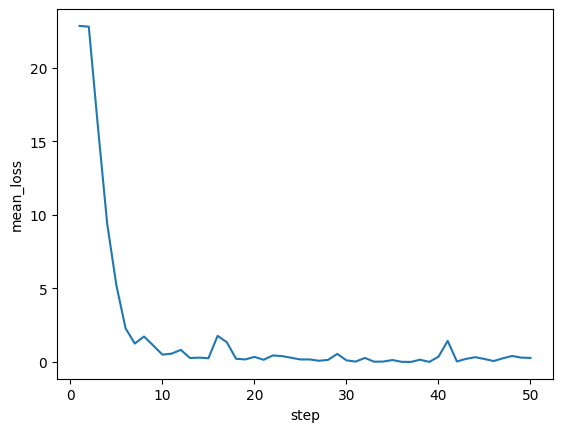

In [21]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")


Este es el nuevo modelo con un cambio en las épocas del modelo

State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='step', ylabel='mean_loss'>

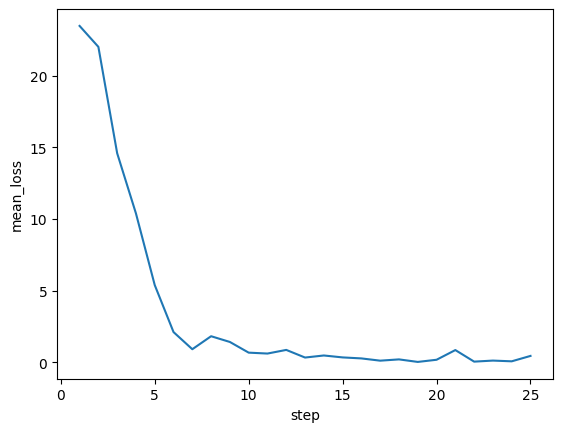

In [30]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")


Note that the `seaborn` module may output warnings containing `FutureWarning: use_inf_as_na option is deprecated`. These are expected and can be ignored.

## Use the new model

Now that you have a tuned model, try it out with custom data. You use the same API as a normal Gemini API interaction, but you specify your new model as the model name, using the `tunedModels/` prefix.

In [22]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


Nuevo modelo

In [31]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


### Evaluation

You can see that the model outputs labels that correspond to those in the training data, and without any system instructions or prompting, which is already a great improvement. Now see how well it performs on the test set.

Note that there is no parallelism in this example; classifying the test sub-set will take a few minutes.

In [23]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 84.38%


Mejoró en gran medida el modelo

In [32]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 68.75%


Pues empeoró :c
Quizás con todo el conjunto de datos se podría hacer mucho mejor el modelo, pero al no tener acceso a un modelo pagado no creo que sea conveniente intentarlo

## Compare token usage

AI Studio and the Gemini API provide model tuning at no cost, however normal limits and charges apply for *use* of a tuned model.

The size of the input prompt and other generation config like system instructions, as well as the number of generated output tokens, all contribute to the overall cost of a request.

In [24]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)
Tuned model: 135 (input)
Token savings: 26.67%


The earlier verbose model also produced more output tokens than needed for this task.

In [25]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 149
Tuned output tokens: 3


## Next steps

Now that you have tuned a classification model, try some other tasks, like tuning a model to respond with a specific tone or style using hand-written examples (or even generated examples!). Kaggle hosts [a number of datasets](https://www.kaggle.com/datasets) you can try out.

Learn about [when supervised fine-tuning is most effective](https://cloud.google.com/blog/products/ai-machine-learning/supervised-fine-tuning-for-gemini-llm).

And check out the [fine-tuning tutorial](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?hl=en&lang=python) for another example that shows a tuned model extending beyond the training data to new, unseen inputs.